# Libraries

In [1]:
from functions import *

# Generate cross section

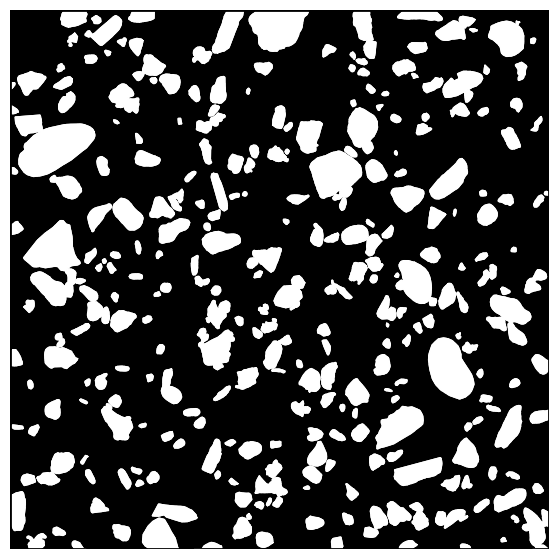

In [2]:
generate_cross_section(img_w_mm=75, img_h_mm=75, n_s=300)


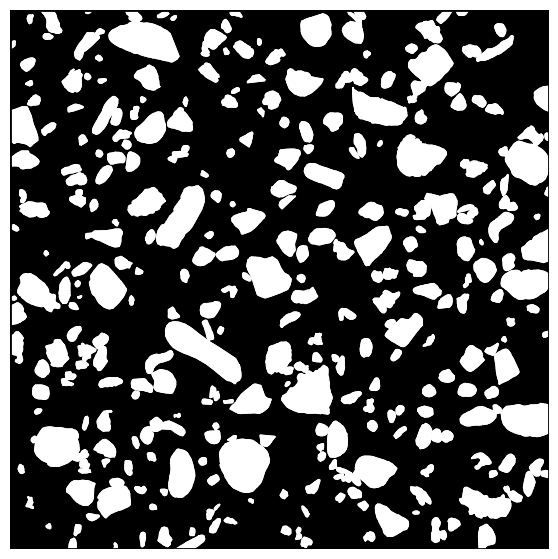

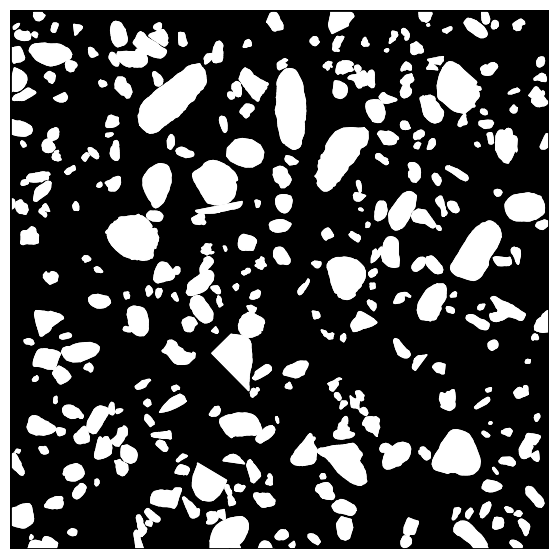

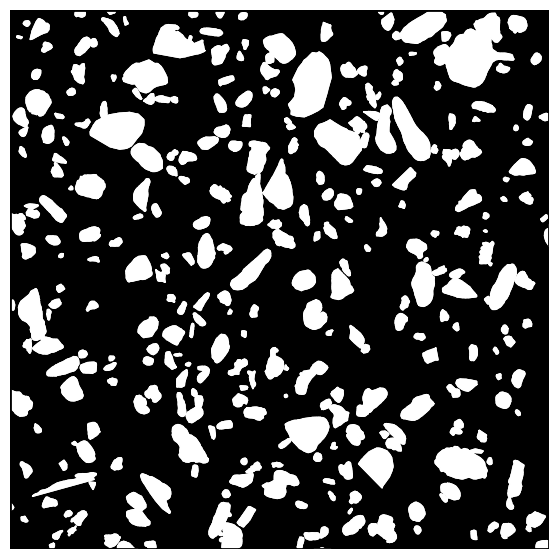

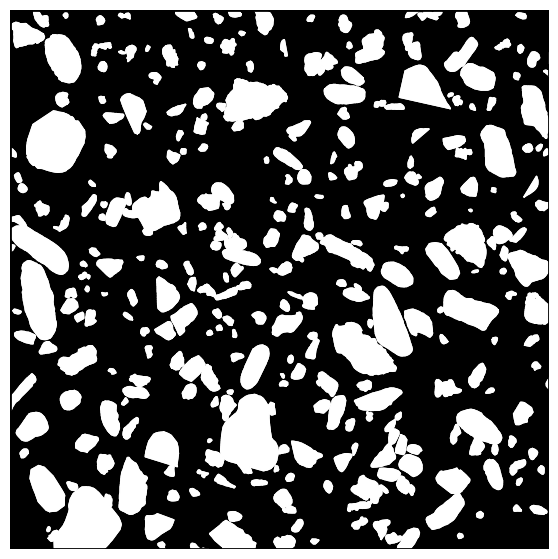

In [3]:
divs = 4
for i in range(divs):
    generate_cross_section(img_w_mm=75, img_h_mm=75, n_s=300, output_json=f"output_contour_{i}.json")

In [ ]:
# div = 2
# df = sort_contours_using_uniform_pdf_and_group("dataset_contours_aggregate_by_patch.csv", "dataset_contours_aggregate_by_patch.json", 4, div)
# df

# color = [
#             '#3a7b9f', '#d4e2c3', '#f0119b', '#a1c935', "#28f8a1",
#             '#ff9000', '#b04c87', '#52e0ff', '#6012ff', '#c0ffee',
#             '#123456', '#654321', '#ff00ff', '#00ff00', '#0000ff',
#             '#abcdef', '#fedcba', '#a0b1c2', '#1f2e3d', '#f0f8ff', '#3a7b9f',    
#         ]

In [4]:
# img_w, img_h = 2500, 2500
# fig, ax = plt.subplots(figsize=(7, 7))
# ax.imshow(np.ones((img_h, img_w)), cmap="gray")
# for k in [1, 2, 3, 4, 5]:# , div+1):
#     df_group = df[df['group by diameter (px)'] == k].reset_index(drop=True)
#     target_size = df_group['diameter (px)'].max() + 50
#     nx = int(round(img_w / target_size))
#     ny = int(round(img_h / target_size))
#     cell_w = img_w / nx
#     cell_h = img_h / ny
#     centers = []
#     ids = []
#     if k > 1:
#         quad_contours = []
#     for j in range(ny):
#         for i in range(nx):
#             cx = (i + 0.5) * cell_w
#             cy = (j + 0.5) * cell_h
#             centers.append((cx, cy))
#             ids.append(j * nx + i)
#             if k > 1:
#                 # quad_contours.append([(cx - cell_w / 2, cy - cell_h / 2), (cx + cell_w / 2, cy - cell_h / 2), (cx + cell_w / 2, cy + cell_h / 2), (cx - cell_w / 2, cy + cell_h / 2)])
#                 n = 5
#                 quad_contours.append([(cx - (cell_w-n) / 2, cy - (cell_h-n) / 2), (cx + (cell_w-n) / 2, cy - (cell_h-n) / 2), (cx + (cell_w-n) / 2, cy + (cell_h-n) / 2), (cx - (cell_w-n) / 2, cy + (cell_h-n) / 2)])
#     center_ids_selected = np.random.choice(ids, size=len(df_group), replace=False)
#     centers = np.array(centers)

#     # Check colision
#     if k > 1:
#         colision_bin = [0] * len(quad_contours)
#         for i, quad in enumerate(quad_contours):
#             quad_poly = sh.geometry.Polygon(quad)
#             for cont in contours:
#                 if quad_poly.intersects(sh.geometry.Polygon(cont)):
#                     colision_bin[i] = 1
#                     break
#         ids_temp = [i for i in range(len(quad_contours)) if colision_bin[i] == 0]
#         if len(ids_temp) < len(df_group):
#             center_ids_selected = np.random.choice(ids_temp, size=len(ids_temp), replace=False)
#         else:
#             center_ids_selected = np.random.choice(ids_temp, size=len(df_group), replace=False)

#     if k == 4:
#         for i in range(nx + 1):
#             x = i * cell_w
#             ax.axvline(x, color='blue', linewidth=1)
#         for j in range(ny + 1):
#             y = j * cell_h
#             ax.axhline(y, color='blue', linewidth=1)
#     if k <= 1:
#         contours = []
#     for m, row in df_group.iterrows():
#         print(m)
#         x_df = row['x coordinate in 0,0']
#         y_df = row['y coordinate in 0,0']
#         cx, cy = centers[center_ids_selected[m], 0], centers[center_ids_selected[m], 1]
#         cx_noise = noise_point([cx], value_noise=1)
#         cy_noise = noise_point([cy], value_noise=1)
#         ax.scatter(cx_noise, cy_noise, c='red', s=2)
#         x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
#         contours.append(list(zip(x_new, y_new)))
#         ax.plot(x_new, y_new, color[k])
#         ax.fill(x_new, y_new, color[k], alpha=0.3)
# plt.show()

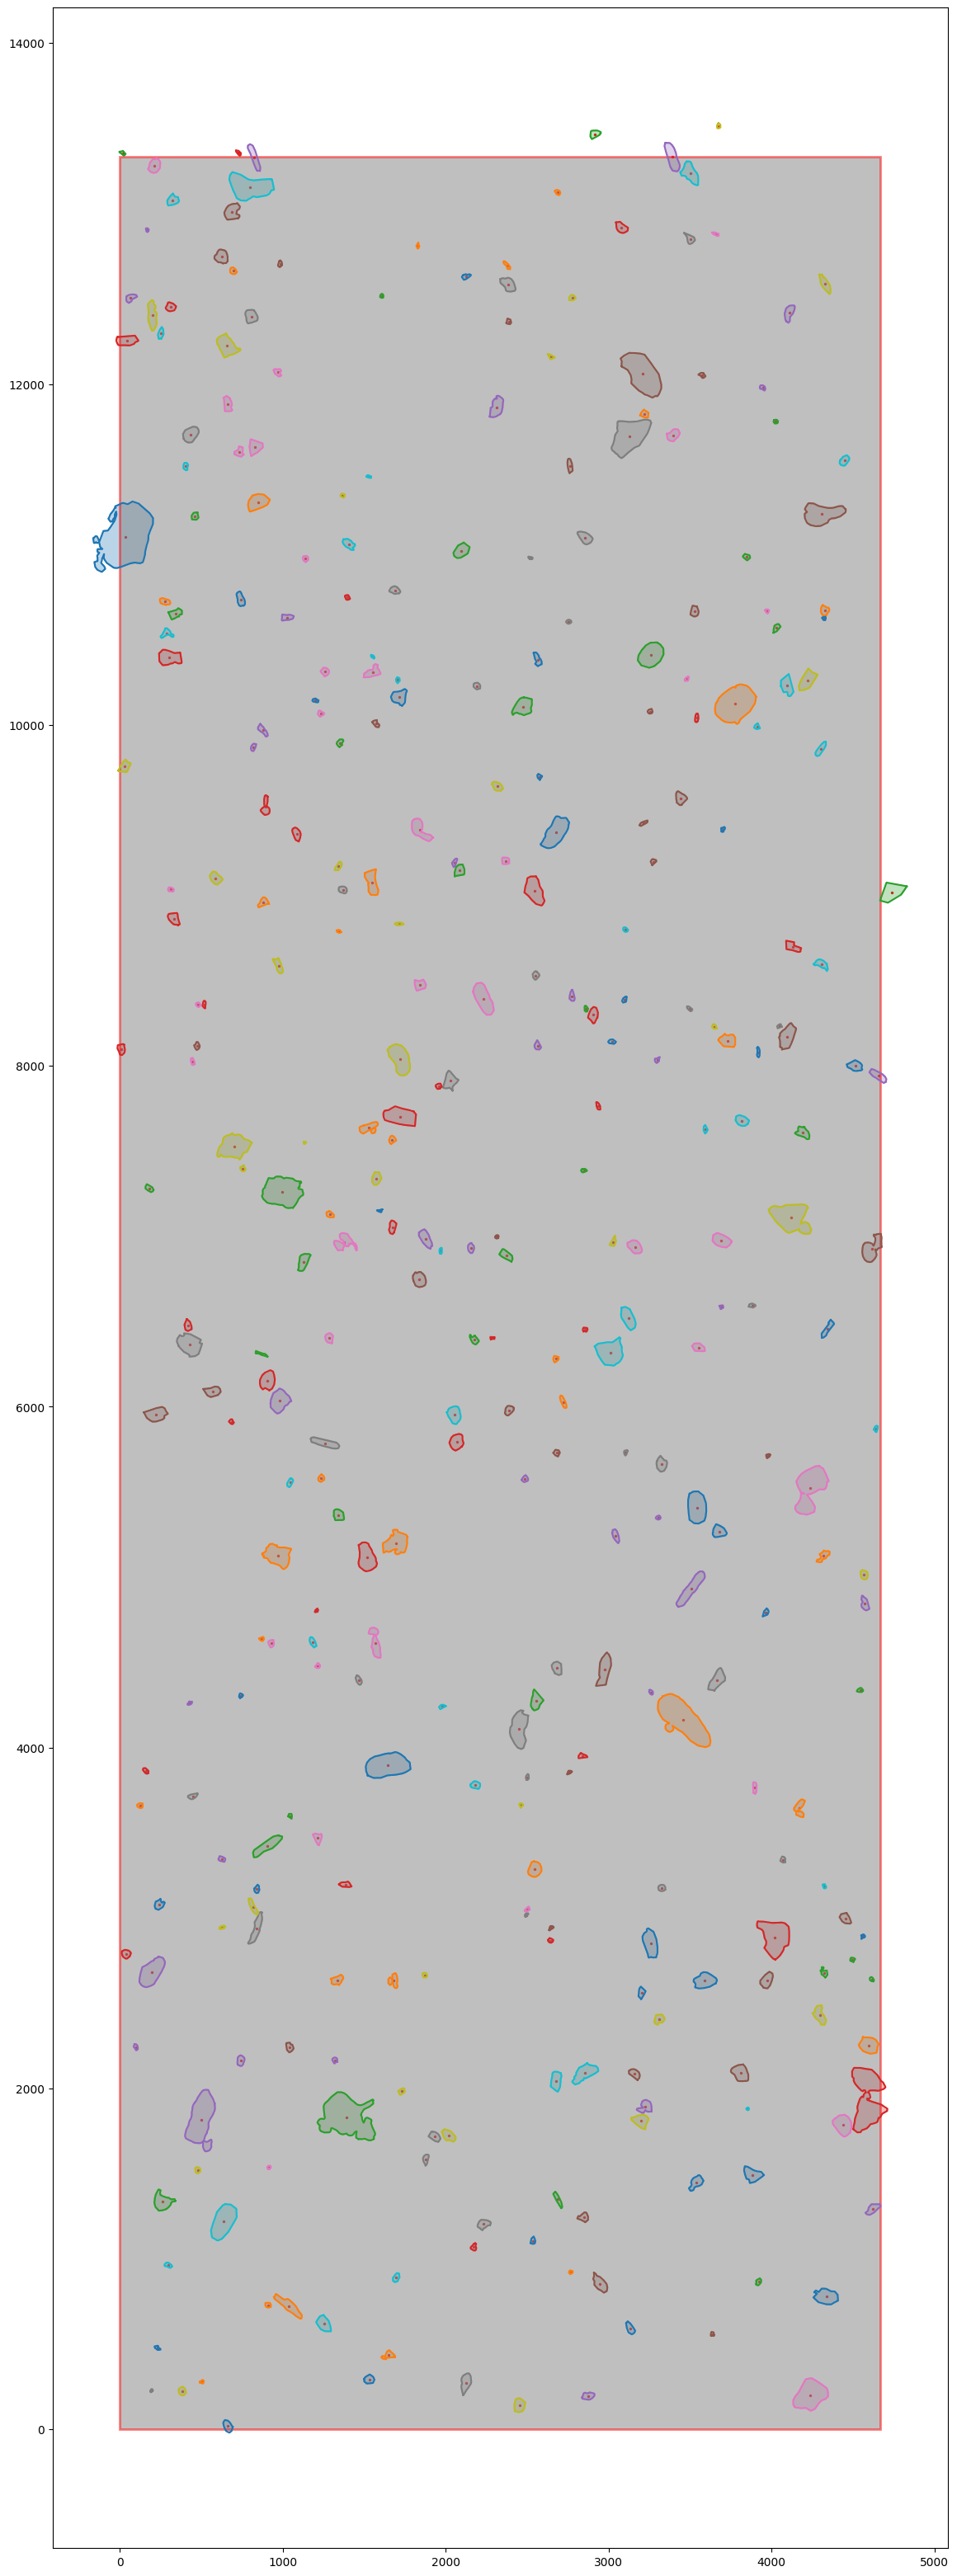

In [ ]:
# img_w, img_h = 140, 400

# # Dataset extract
# df = sort_contours_using_uniform_pdf_and_group("dataset_contours_aggregate_by_patch.csv", "dataset_contours_aggregate_by_patch.json", 350)

# # Convert mm to px
# img_w = img_w * 2500 / 75
# img_h = img_h * 2500 / 75

# # Start process
# fig, ax = plt.subplots(figsize=(14, 40))
# retan = patches.Rectangle((0, 0), img_w, img_h, 
#                              linewidth=2, edgecolor='r', 
#                              facecolor='gray', alpha=0.5)
# contours = []
# collision_control = []
# for m, row in df.iterrows():
#     if m < 1:
#         n = 1
#         sampler = sc.stats.qmc.LatinHypercube(d=2)
#         sample = sampler.random(n=n)
#         centroids = sc.stats.qmc.scale(sample, [0, 0], [img_w, img_h])
#         x_df = row['x coordinate in 0,0']
#         y_df = row['y coordinate in 0,0']
#         cx, cy = centroids[0, 0], centroids[0, 1]
#         cx_noise = noise_point([cx], value_noise=1)
#         cy_noise = noise_point([cy], value_noise=1)
#         x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
#         current_contour = list(zip(x_new, y_new))
#         contours.append(current_contour)
#         ax.scatter(cx_noise, cy_noise, c='red', s=2)
#         ax.plot(x_new, y_new)
#         ax.fill(x_new, y_new, alpha=0.3)
#     else:
#         th = True
#         max_iter = 0
#         while th and max_iter < 100:
#             # print("max_iter:", max_iter)
#             n = 1
#             sampler = sc.stats.qmc.LatinHypercube(d=2)
#             sample = sampler.random(n=n)
#             centroids = sc.stats.qmc.scale(sample, [0, 0], [img_w, img_h])
#             x_df = row['x coordinate in 0,0']
#             y_df = row['y coordinate in 0,0']
#             cx, cy = centroids[0, 0], centroids[0, 1]
#             cx_noise = noise_point([cx], value_noise=2)
#             cy_noise = noise_point([cy], value_noise=2)
#             x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
#             current_contour = list(zip(x_new, y_new))
#             for _, quad in enumerate([current_contour]):
#                 quad_poly = sh.geometry.Polygon(quad)
#                 for cont in contours:
#                     th = quad_poly.intersects(sh.geometry.Polygon(cont))
#                     # print("th:", th)
#                     if th:
#                         # print("Collision detected, retrying...")
#                         break
#             if th==False:
#                 # print("passei aqui no False th...")
#                 contours.append(current_contour)
#                 ax.scatter(cx_noise, cy_noise, c='red', s=2)
#                 ax.plot(x_new, y_new)
#                 ax.fill(x_new, y_new, alpha=0.3)
#                 break
#             else:
#                 # print("Another try...")
#                 pass
#             max_iter += 1
# ax.add_patch(retan)  
# plt.savefig('viga.png', dpi=300, bbox_inches='tight')  # Formato PNG
# plt.show()

In [ ]:
# # For que realiza o recorte dos contornos
# new_contours = []
# for cont in contours:
#     xs, ys = zip(*cont)
#     xs = np.array(xs)
#     ys = np.array(ys)

#     # Verifica se TODOS os pontos estão fora 
#     all_out_x = np.all((xs < 0) | (xs > img_w))
#     all_out_y = np.all((ys < 0) | (ys > img_h))
#     if all_out_x or all_out_y:
#         # Remove o contorno completamente
#         continue
    
#     # Limita os pontos para a borda
#     xs_clipped = np.clip(xs, 0, img_w)
#     ys_clipped = np.clip(ys, 0, img_h)

#     clipped_contour = list(zip(xs_clipped, ys_clipped))
#     new_contours.append(clipped_contour)


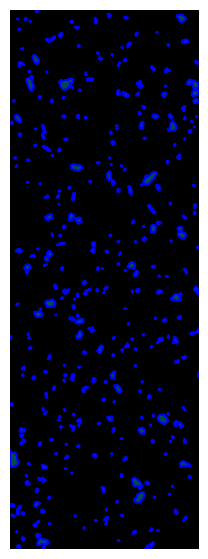

In [ ]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(7, 7))
# ax.imshow(np.ones((int(img_h), int(img_w))), cmap="gray")  # Fundo branco (1 = branco em cmap gray)

# for cont in new_contours:
#     xs, ys = zip(*cont)
#     ax.plot(xs, ys, color='blue')
#     ax.fill(xs, ys, alpha=0.3, color='cyan')

# ax.set_xlim(0, img_w)
# ax.set_ylim(img_h, 0)  # Inverte eixo y para imagem ficar "normal"
# ax.axis('off')  # Opcional, para esconder os eixos

# plt.show()

# Gross section generator

In [8]:
# generate_canvas_from_json("dataset_contours_aggregate_by_patch.json", (2500, 2500), 300)

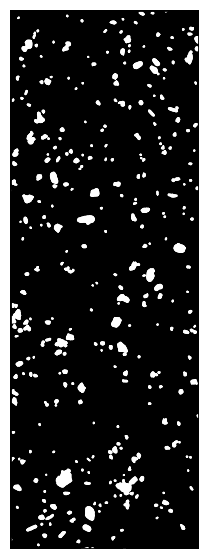

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import shapely as sh
# import scipy as sc
# import json



